In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
iris = pd.read_csv('iris.csv')
iris.head(2)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa


In [3]:
iris.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')

In [4]:
iris.isna().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [5]:
dataframe=iris.copy()

In [6]:
dataframe['sepal_length']

0      5.1
1      4.9
2      4.7
3      4.6
4      5.0
      ... 
145    6.7
146    6.3
147    6.5
148    6.2
149    5.9
Name: sepal_length, Length: 150, dtype: float64

In [7]:
data=dataframe['sepal_width'].to_numpy()

### Use library i.e pymc3 or arviz and plot the above data on KDE plot 

<AxesSubplot: >

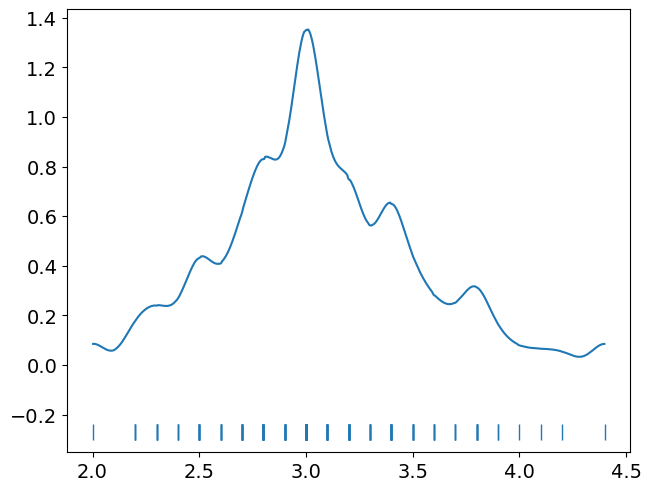

In [8]:
az.plot_kde(data, rug=True)

# creation of the Model here 

In [9]:
with pm.Model() as model_iris:
    μ = pm.Uniform('μ', lower=0, upper=6)
    σ = pm.HalfNormal('σ', sd=2)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    idata_g = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.


# write code here for pair plot and check the estemate for two priors

C:\Users\MSA\anaconda3\envs\pm3bap\lib\site-packages\arviz\plots\jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")


array([<AxesSubplot: xlabel='μ', ylabel='σ'>, <AxesSubplot: >,
       <AxesSubplot: >], dtype=object)

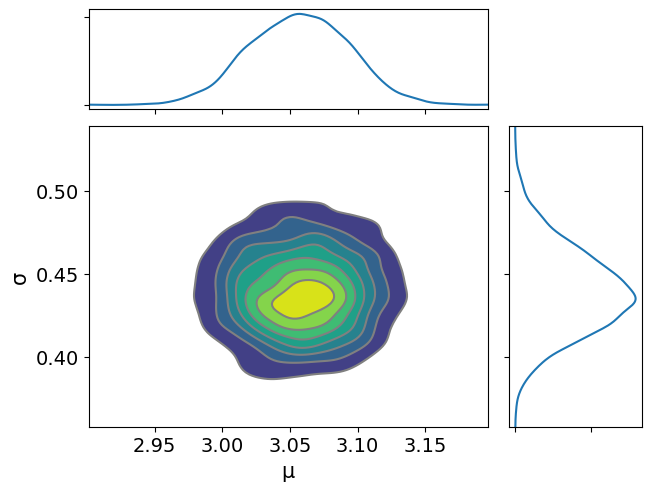

In [11]:
az.plot_joint(idata_g, kind='kde', fill_last=False)

array([[<AxesSubplot: title={'center': 'μ'}>,
        <AxesSubplot: title={'center': 'μ'}>],
       [<AxesSubplot: title={'center': 'σ'}>,
        <AxesSubplot: title={'center': 'σ'}>]], dtype=object)

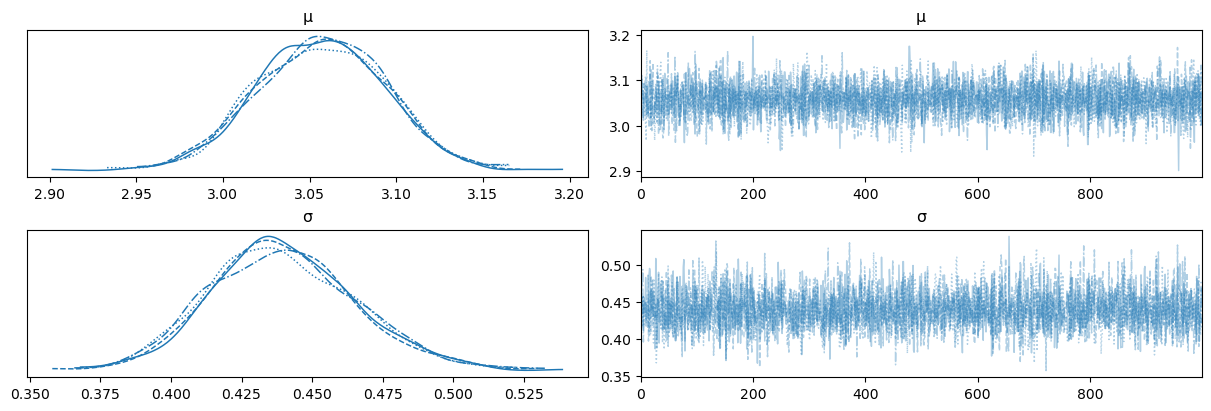

In [12]:
az.plot_trace(idata_g)

# write code here to summarise the results

In [13]:
az.summary(idata_g)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,3.057,0.037,2.991,3.126,0.001,0.0,3912.0,2894.0,1.0
σ,0.440,0.026,0.394,0.489,0.000,0.0,3581.0,3038.0,1.0


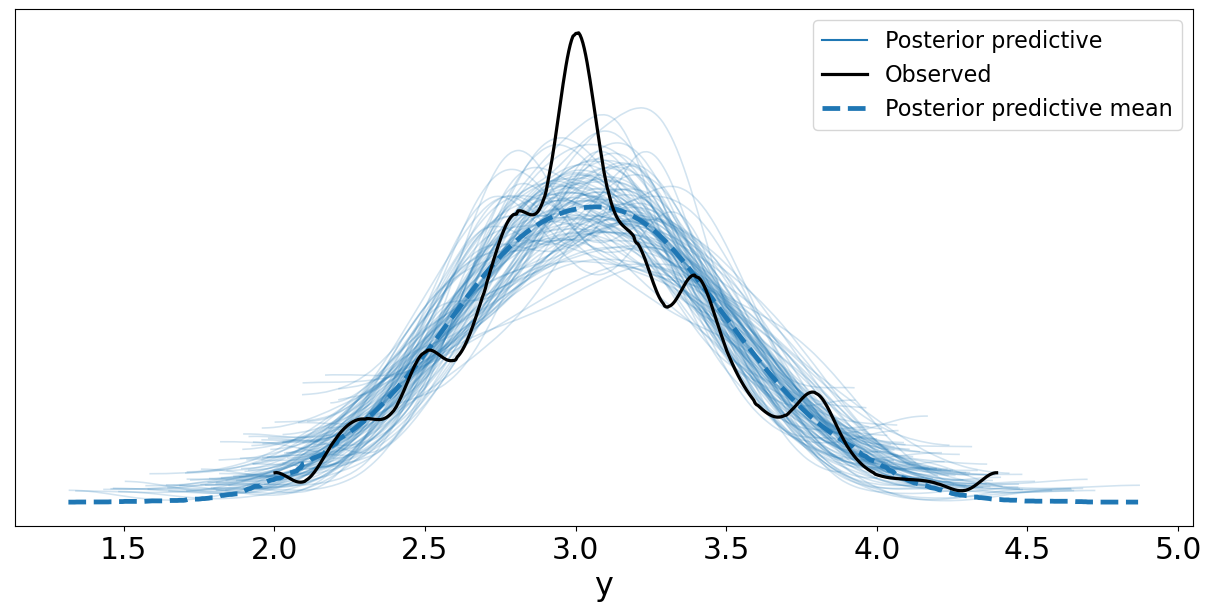

In [14]:
y_pred_g = pm.sample_posterior_predictive(idata_g, model=model_iris, keep_size=True)
az.concat(idata_g, az.from_dict(posterior_predictive=y_pred_g), inplace=True)
ax = az.plot_ppc(idata_g, num_pp_samples=100, figsize=(12, 6), mean=True)

# You can work on Student T model incase if results are not robust from above model?

In [15]:
with pm.Model() as model_iris_t:
    μ = pm.Uniform('μ', 0,6)
    σ = pm.HalfNormal('σ', sd=2)
    ν = pm.Exponential('ν', 1/3)
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)
    idata_t = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
The acceptance probability does not match the target. It is 0.8820043711700399, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<AxesSubplot: title={'center': 'μ'}>,
        <AxesSubplot: title={'center': 'μ'}>],
       [<AxesSubplot: title={'center': 'σ'}>,
        <AxesSubplot: title={'center': 'σ'}>],
       [<AxesSubplot: title={'center': 'ν'}>,
        <AxesSubplot: title={'center': 'ν'}>]], dtype=object)

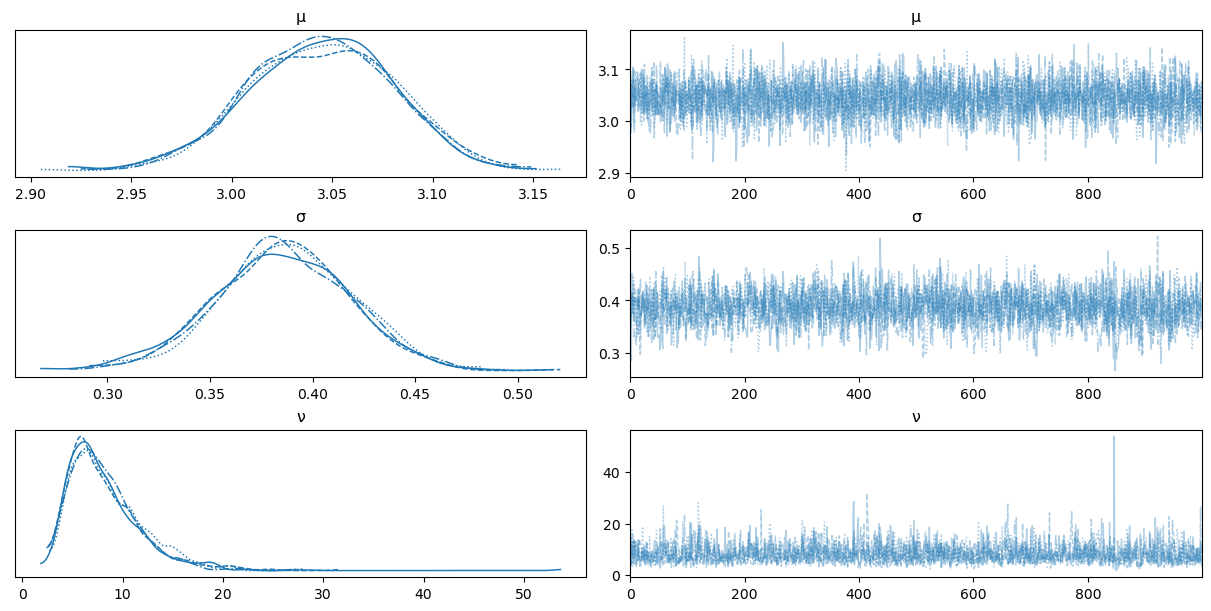

In [16]:
az.plot_trace(idata_t)

In [17]:
az.summary(idata_t)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,3.045,0.035,2.979,3.109,0.001,0.000,3405.0,2873.0,1.0
σ,0.386,0.032,0.329,0.450,0.001,0.001,1998.0,1904.0,1.0
ν,8.250,3.649,2.859,14.813,0.078,0.055,1960.0,2361.0,1.0


<AxesSubplot: xlabel='y'>

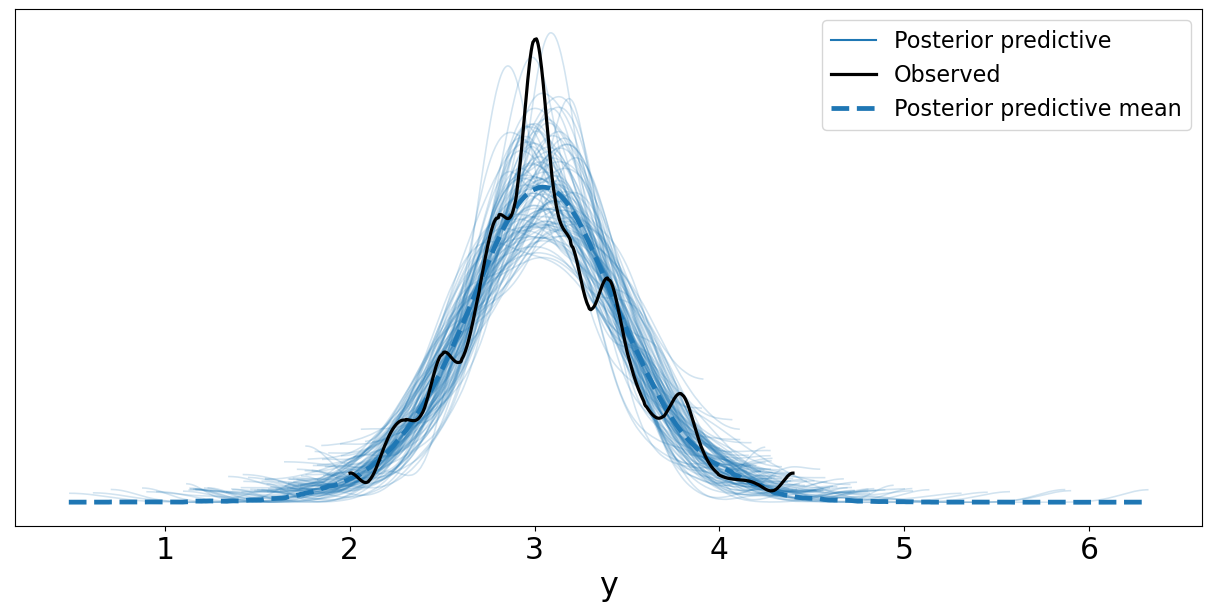

In [18]:
y_ppc_t = pm.sample_posterior_predictive(idata_t, model=model_iris_t, random_seed=123, keep_size=True)
az.concat(idata_t, az.from_dict(posterior_predictive=y_ppc_t), inplace=True)
az.plot_ppc(idata_t, num_pp_samples=100, figsize=(12, 6), mean=True)

# Conclusion:
    Using student's T model, there are more peaks and samples are better align with the observed data. As the mean predictive posterior shows that Student T model is more robust.

# Group Comparison 

In [19]:
com = iris['sepal_width'].values
idx = pd.Categorical(iris['species'], categories=['versicolor', 'setosa', 'virginica']).codes
groups = len(np.unique(idx))

<AxesSubplot: xlabel='species', ylabel='sepal_width'>

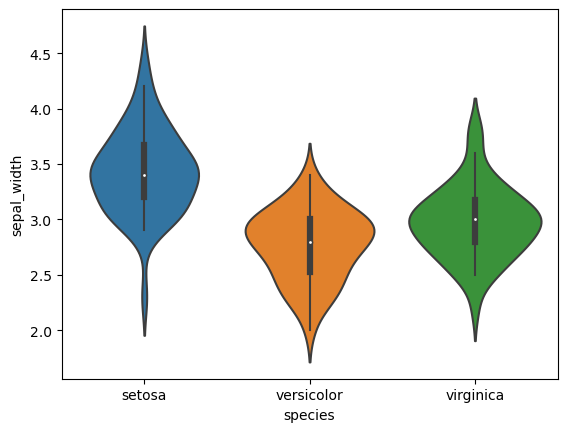

In [20]:
sns.violinplot(x='species', y='sepal_width', data=iris)

<AxesSubplot: xlabel='species', ylabel='sepal_length'>

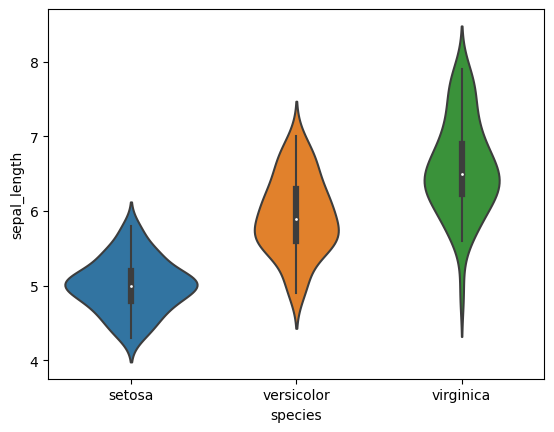

In [21]:
sns.violinplot(x='species', y='sepal_length', data=iris)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
C:\Users\MSA\anaconda3\envs\pm3bap\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot: title={'center': 'μ'}>,
        <AxesSubplot: title={'center': 'μ'}>],
       [<AxesSubplot: title={'center': 'σ'}>,
        <AxesSubplot: title={'center': 'σ'}>]], dtype=object)

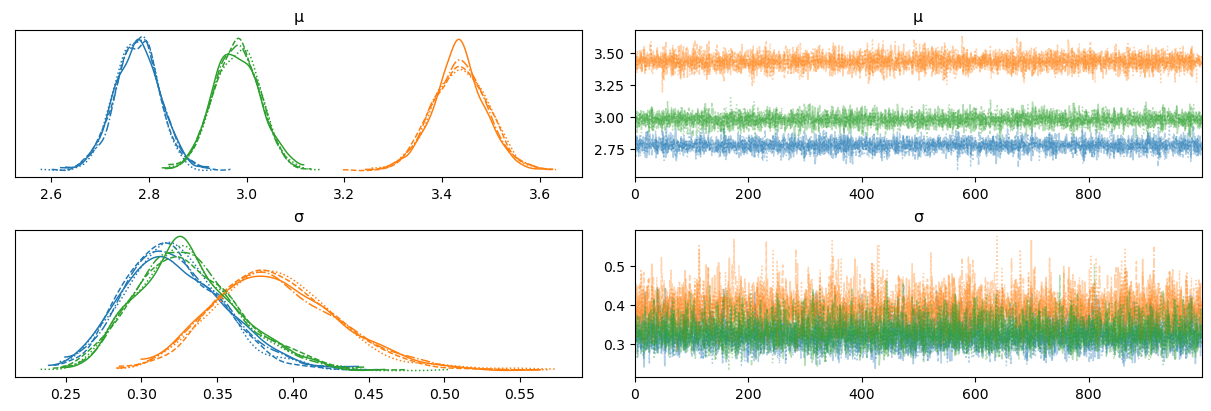

In [22]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=6, sd=1, shape=groups)
    σ = pm.HalfNormal('σ', sd=1, shape=groups)
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=com)
    idata_cg = pm.sample(1000, return_inferencedata=False)
    
az.plot_trace(idata_cg)

In [23]:
az.summary(idata_cg)

C:\Users\MSA\anaconda3\envs\pm3bap\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],2.776,0.046,2.689,2.861,0.001,0.0,4729.0,3167.0,1.0
μ[1],3.436,0.055,3.333,3.540,0.001,0.0,6329.0,3260.0,1.0
μ[2],2.980,0.047,2.895,3.071,0.001,0.0,6215.0,3215.0,1.0
σ[0],0.322,0.033,0.264,0.384,0.000,0.0,5180.0,3131.0,1.0
σ[1],0.389,0.041,0.315,0.467,0.001,0.0,5921.0,2708.0,1.0
σ[2],0.331,0.034,0.274,0.400,0.000,0.0,5964.0,3207.0,1.0


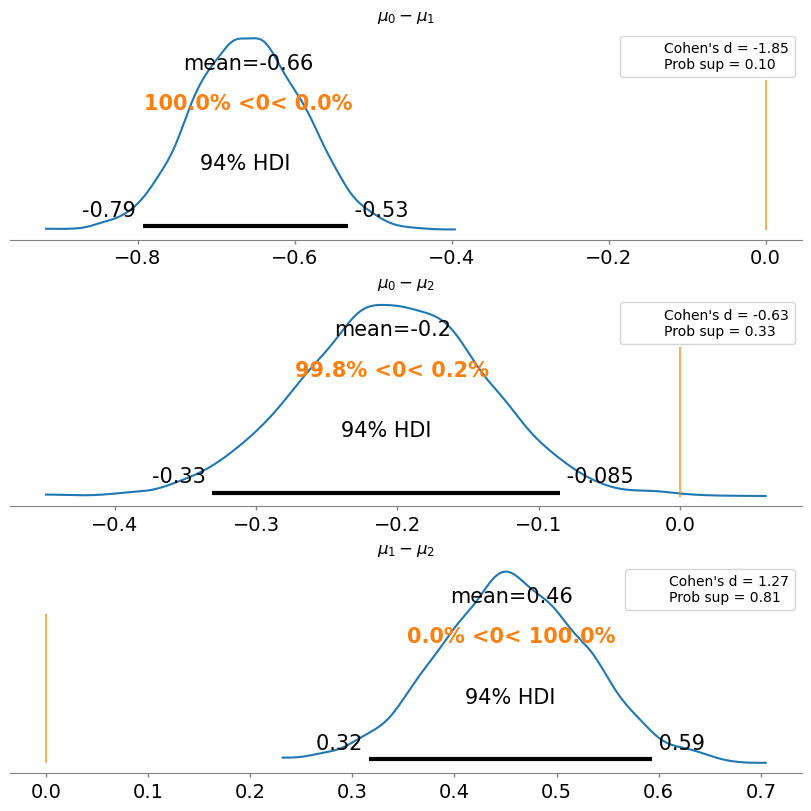

In [24]:
dist = stats.norm()

_, ax = plt.subplots(3, 1, figsize=(8, 8), constrained_layout=True)

comparisons = [(i, j) for i in range(3) for j in range(i+1, 3)]
pos = [(k) for k in range(3)]

for (i, j), (k) in zip(comparisons, pos):
    means_diff = idata_cg['μ'][:, i] - idata_cg['μ'][:, j]
    d_cohen =  (means_diff / np.sqrt((idata_cg['σ'][:, i]**2 + idata_cg['σ'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))

    az.plot_posterior(means_diff, ref_val=0, ax=ax[k])
    ax[k].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k].plot(0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k].legend()

# Cohen's d effect size:
    The Cohen's d for the groups 0 and 1 is -1.86 indicating a large effect size. Similarly it's value for groups 0 and 2 is -0.63 indicating a medium effect size. The effect size for the difference between groups 1 and 2 is 1.27 indicating a moderately large effect size.

# Probability of superiority:
    The probability of superiority for the difference between groups 0 and 1 is 0.09, indicating that there is a 9% probability that a randomly selected observation from group 0 will be larger than a randomly selected observation from group 1. Similarly it's value for groups 0 and 2 is 0.33 indicating that there is a 33% chance that a randomly selected observation from group 0 will be larger than a randomly selected observation from group 2. The probability of superiority for the difference between groups 1 and 2 is 0.82, indicating that there is an 82% probability that a randomly selected observation from group 1 will be larger than a randomly selected observation from group 2.

# Conclusion:
    The effect sizes and probabilities of superiority suggest that the mean sepal width of group 0 is significantly smaller than that of group 1, and is likely to be smaller than that of group 2 as well. There is also a moderate effect size for the difference in mean sepal width between groups 1 and 2, with a high probability of superiority indicating that the mean sepal width of group 1 is likely to be larger than that of group 2. 
